In [1]:
import pandas as pd
import os
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
merge_directory = "/shared/3/projects/bangzhao/prosodic_embeddings/merge/output/"

## check the merge file

In [15]:
def read_single_csv(directory_path):
    """
    Reads the first CSV file in the specified directory.
    
    Parameters:
    - directory_path (str): The path to the directory containing the CSV files.
    
    Returns:
    - DataFrame: The content of the first CSV file.
    """
    # Step 1: List all CSV files in the directory
    all_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    
    # Step 2: Check if there are any CSV files in the directory
    if not all_files:
        print("No CSV files found in the directory.")
        return None

    # Step 3: Get the first CSV file (sorted alphabetically by default)
    first_file = all_files[0]
    first_file_path = os.path.join(directory_path, first_file)
    
    print(f"Reading the first CSV file: {first_file_path}")
    
    # Step 4: Read the CSV file using pandas
    try:
        df = pd.read_csv(first_file_path)
        print("Successfully read the first CSV file.")
        return df
    except Exception as e:
        print(f"Error reading {first_file_path}: {e}")
        return None

In [16]:
single_merge_file = read_single_csv(merge_directory)

Reading the first CSV file: /shared/3/projects/bangzhao/prosodic_embeddings/merge/output/52-httpsanchor.fms1e072fecpodcastplay13919446https3A2F2Fd3ctxlq1ktw2nl.cloudfront.net2Fstaging2F20204182F74298296441002a2c5a9a88ead5.m4a.csv
Successfully read the first CSV file.


In [22]:
single_merge_file.head()

,index,start,end,content,Type,Speaker,F0semitoneFrom27.5Hz_sma3nz,F1frequency_sma3nz,mfcc1_sma3,mfcc2_sma3,mfcc3_sma3,mfcc4_sma3,F0semitoneFrom27.5Hz_sma3nzSlope,F1frequency_sma3nzSlope,mfcc1_sma3Slope,mfcc2_sma3Slope,mfcc3_sma3Slope,mfcc4_sma3Slope
0,0,2.43,2.81,welcome,words,cache_480_4083528,17.234438,584.503534,41.266139,23.821282,15.521938,13.536497,3.259381,34.163139,-4.671607,-3.309629,-5.229971,-5.306966
1,1,2.81,3.25,to,words,cache_480_4083528,24.556078,482.307767,37.632721,25.033171,17.169768,3.274008,17.883903,-352.841561,83.163776,19.309329,-42.011981,25.773972
2,2,3.68,4.08,minusha,words,cache_480_4083528,21.525666,599.034387,40.240698,24.128187,13.488455,9.226539,20.347170,-14.189689,-22.526361,-21.185327,23.947902,-23.222636
3,3,4.08,4.33,and,words,cache_480_4083528,33.543607,784.384399,44.728942,4.623534,6.281787,-6.183116,-20.515468,-579.380638,18.963692,130.650858,4.366130,-30.678187
4,4,4.33,4.39,the,words,cache_480_4083528,30.877412,665.130758,47.331496,11.150508,-0.936611,-13.877925,-14.169455,-949.414062,97.003841,-329.603541,-394.298160,-137.753963


## Sample 10k Episodes and Concatenate

In [32]:
def sample_and_save_part(input_directory, output_file, sample_size=1000, start_index=0, end_index=0):
    """
    Sample a specified number of CSV files from a subset of a directory,
    concatenate them, and save as a single CSV file.
    """
    # Get all CSV files in the specified range
    all_files = [f for i, f in enumerate(os.listdir(input_directory)) 
                 if f.endswith('.csv') and start_index <= i < end_index]
    
    if len(all_files) < sample_size:
        print(f"Not enough files to sample. Found only {len(all_files)} CSV files in range {start_index}-{end_index}.")
        return
    
    # Sample 1,000 files from the current part
    sampled_files = random.sample(all_files, sample_size)
    dataframes = []

    for file in tqdm(sampled_files, desc=f"Processing part {start_index // (end_index - start_index)}", unit="file"):
        file_path = os.path.join(input_directory, file)
        try:
            df = pd.read_csv(file_path)
            df['source_file'] = file
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    # Concatenate and save the sampled files for this part
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.to_csv(output_file, index=False)
    print(f"Saved {sample_size} sampled files into {output_file}")

In [37]:
def concatenate_parts(output_directory, final_output_file):
    """
    Concatenate all intermediate CSV files into one final CSV file with a progress bar.
    """
    # Find all CSV files in the output directory that start with 'part_' and end with '.csv'
    all_parts = [f for f in os.listdir(output_directory) if f.startswith('part_') and f.endswith('.csv')]
    
    # Initialize an empty list to store DataFrames
    dataframes = []

    # Read and concatenate each CSV file with a progress bar
    print("Concatenating CSV files...")
    for part in tqdm(all_parts, desc="Processing files", unit="file"):
        part_path = os.path.join(output_directory, part)
        df = pd.read_csv(part_path)
        dataframes.append(df)
    
    # Concatenate all parts into a single DataFrame
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    # Save the concatenated DataFrame to a CSV file
    combined_df.to_csv(final_output_file, index=False)
    print(f"Successfully saved all parts into {final_output_file}")

In [35]:
# Step 1: Divide the files into 10 parts and process each part
output_directory = '/shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/'
total_files = len([f for f in os.listdir(merge_directory) if f.endswith('.csv')])
files_per_part = total_files // 10

for i in range(10):
    start_index = i * files_per_part
    end_index = (i + 1) * files_per_part
    output_file = os.path.join(output_directory, f'part_{i + 1}.csv')
    sample_and_save_part(merge_directory, output_file, sample_size=1000, start_index=start_index, end_index=end_index)

Processing part 0: 100%|██████████████████| 1000/1000 [01:19<00:00, 12.57file/s]


Saved 1000 sampled files into /shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/part_1.csv


Processing part 1: 100%|██████████████████| 1000/1000 [01:06<00:00, 14.96file/s]


Saved 1000 sampled files into /shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/part_2.csv


Processing part 2: 100%|██████████████████| 1000/1000 [01:23<00:00, 12.02file/s]


Saved 1000 sampled files into /shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/part_3.csv


Processing part 3: 100%|██████████████████| 1000/1000 [01:21<00:00, 12.31file/s]


Saved 1000 sampled files into /shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/part_4.csv


Processing part 4: 100%|██████████████████| 1000/1000 [01:17<00:00, 12.95file/s]


Saved 1000 sampled files into /shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/part_5.csv


Processing part 5: 100%|██████████████████| 1000/1000 [01:22<00:00, 12.11file/s]


Saved 1000 sampled files into /shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/part_6.csv


Processing part 6: 100%|██████████████████| 1000/1000 [01:23<00:00, 11.96file/s]


Saved 1000 sampled files into /shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/part_7.csv


Processing part 7: 100%|██████████████████| 1000/1000 [01:21<00:00, 12.20file/s]


Saved 1000 sampled files into /shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/part_8.csv


Processing part 8: 100%|██████████████████| 1000/1000 [01:32<00:00, 10.76file/s]


Saved 1000 sampled files into /shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/part_9.csv


Processing part 9: 100%|██████████████████| 1000/1000 [01:41<00:00,  9.86file/s]


Saved 1000 sampled files into /shared/3/projects/bangzhao/prosodic_embeddings/sample/temp/part_10.csv


In [38]:
# Step 2: Concatenate the 10 intermediate files into one large CSV
final_output_file = '/shared/3/projects/bangzhao/prosodic_embeddings/sample/10k_episode_sample.csv'
concatenate_parts(output_directory, final_output_file)

Concatenating CSV files...


Processing files: 100%|███████████████████████| 10/10 [08:39<00:00, 51.94s/file]


Successfully saved all parts into /shared/3/projects/bangzhao/prosodic_embeddings/sample/10k_episode_sample.csv


## Sample Chunks of Rows from the Sampled Episodes

In [39]:
def sample_chunks_from_large_csv(input_file, output_file, chunk_size=512, num_chunks_to_sample=10000):
    """
    Sample 10,000 chunks of 512 rows from a large CSV file and save to a new CSV file.
    """
    # Step 1: Calculate the total number of chunks
    total_rows = sum(1 for _ in open(input_file)) - 1  # Subtract 1 for the header row
    total_chunks = total_rows // chunk_size

    if num_chunks_to_sample > total_chunks:
        print(f"Not enough chunks to sample. Total available chunks: {total_chunks}")
        return

    # Step 2: Randomly select the chunk indices to sample
    sampled_chunk_indices = set(random.sample(range(total_chunks), num_chunks_to_sample))
    
    # Step 3: Read the CSV file in chunks and store the sampled chunks
    sampled_chunks = []
    with pd.read_csv(input_file, chunksize=chunk_size, iterator=True) as reader:
        for chunk_index, chunk in tqdm(enumerate(reader), total=total_chunks, desc="Processing chunks"):
            # If the current chunk index is in the sampled set, store it
            if chunk_index in sampled_chunk_indices:
                sampled_chunks.append(chunk)
            
            # Stop if we've collected enough chunks
            if len(sampled_chunks) >= num_chunks_to_sample:
                break

    # Step 4: Concatenate sampled chunks and save to a new CSV
    combined_df = pd.concat(sampled_chunks, ignore_index=True)
    combined_df.to_csv(output_file, index=False)
    print(f"Sampled chunks saved to {output_file}")

In [40]:
# Example usage
output_file = '/shared/3/projects/bangzhao/prosodic_embeddings/sample/10k_episodes_10k_chunks_sampled.csv'
sample_chunks_from_large_csv(final_output_file, output_file)

Processing chunks: 100%|████████████████▉| 79284/79288 [08:49<00:00, 149.77it/s]


Sampled chunks saved to /shared/3/projects/bangzhao/prosodic_embeddings/sample/10k_episodes_10k_chunks_sampled.csv


## Data Cleaning

In [41]:
sample_10k = pd.read_csv(output_file)

In [44]:
sample_10k.head()

,index,start,end,content,Type,Speaker,F0semitoneFrom27.5Hz_sma3nz,F1frequency_sma3nz,mfcc1_sma3,mfcc2_sma3,mfcc3_sma3,mfcc4_sma3,F0semitoneFrom27.5Hz_sma3nzSlope,F1frequency_sma3nzSlope,mfcc1_sma3Slope,mfcc2_sma3Slope,mfcc3_sma3Slope,mfcc4_sma3Slope,source_file
0,1024,357.49,357.56,of,words,cache_55632_733204,13.372669,709.972252,17.627483,11.882088,16.337697,3.473034,-538.578081,6524.478912,-376.016708,164.729478,230.000696,300.470206,22700-httpsinjector.simplecastaudio.combff61c5...
1,1025,357.56,357.94,february,words,cache_55632_733204,25.560986,526.965713,32.997189,5.850077,11.350032,-3.486887,-61.509885,-235.190234,69.452360,23.128781,-40.124914,-8.078765,22700-httpsinjector.simplecastaudio.combff61c5...
2,1026,358.78,359.03,but,words,cache_55632_733204,6.901864,743.787904,8.244580,5.885458,13.293003,-0.155409,28.414856,-217.811986,19.415308,-8.778166,-1.277758,-55.507402,22700-httpsinjector.simplecastaudio.combff61c5...
3,1027,359.92,360.26,does,words,cache_55632_733204,10.564279,691.468026,10.707017,7.465867,12.070202,-3.605176,31.394321,-324.730716,12.486669,-11.226081,2.389543,-34.655392,22700-httpsinjector.simplecastaudio.combff61c5...
4,1028,360.26,361.07,that,words,cache_55632_733204,30.806327,526.894130,24.568225,-1.291678,16.486000,-25.644237,4.176154,209.619455,-7.214032,-14.171904,-11.736863,-21.604156,22700-httpsinjector.simplecastaudio.combff61c5...


In [46]:
sample_10k.drop(columns=['index', 'start', 'end', 'Type', 'Speaker', 'source_file'], inplace=True)

In [47]:
sample_10k

,content,F0semitoneFrom27.5Hz_sma3nz,F1frequency_sma3nz,mfcc1_sma3,mfcc2_sma3,mfcc3_sma3,mfcc4_sma3,F0semitoneFrom27.5Hz_sma3nzSlope,F1frequency_sma3nzSlope,mfcc1_sma3Slope,mfcc2_sma3Slope,mfcc3_sma3Slope,mfcc4_sma3Slope
0,of,13.372669,709.972252,17.627483,11.882088,16.337697,3.473034,-538.578081,6524.478912,-376.016708,164.729478,230.000696,300.470206
1,february,25.560986,526.965713,32.997189,5.850077,11.350032,-3.486887,-61.509885,-235.190234,69.452360,23.128781,-40.124914,-8.078765
2,but,6.901864,743.787904,8.244580,5.885458,13.293003,-0.155409,28.414856,-217.811986,19.415308,-8.778166,-1.277758,-55.507402
3,does,10.564279,691.468026,10.707017,7.465867,12.070202,-3.605176,31.394321,-324.730716,12.486669,-11.226081,2.389543,-34.655392
4,that,30.806327,526.894130,24.568225,-1.291678,16.486000,-25.644237,4.176154,209.619455,-7.214032,-14.171904,-11.736863,-21.604156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119995,is,24.801724,348.422485,-3.842635,31.195273,-20.521071,13.972470,6.921101,-6153.750610,407.483268,146.085835,-137.399387,325.209951
5119996,a,27.121097,330.940206,23.124772,8.153718,-6.723629,-10.152610,-104.509258,102.655792,404.647708,-730.151421,859.056973,-760.958862
5119997,problem,26.772689,738.819598,24.717551,-8.119457,3.553208,-34.099629,-0.973985,360.463364,-6.293948,11.553092,36.364776,4.664863
5119998,but,29.350603,510.299013,23.557152,-16.624272,1.237855,-19.658682,-22.260890,437.219491,7.836444,-17.406065,-12.072126,-30.715111


In [48]:
output_file = '/shared/3/projects/bangzhao/prosodic_embeddings/sample/10k_episodes_10k_chunks_sampled_clean.csv'
sample_10k.to_csv(output_file, index=False)

## Visualization

In [5]:
output_file = '/shared/3/projects/bangzhao/prosodic_embeddings/sample/10k_episodes_10k_chunks_sampled_clean.csv'
sample_10k = pd.read_csv(output_file)

<Axes: xlabel='F1frequency_sma3nz', ylabel='Count'>

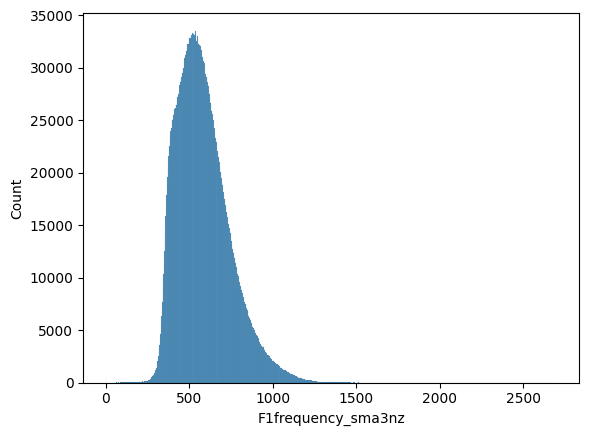

In [6]:
sns.histplot(x='F1frequency_sma3nz', data=sample_10k)

<Axes: xlabel='F0semitoneFrom27.5Hz_sma3nzSlope', ylabel='Count'>

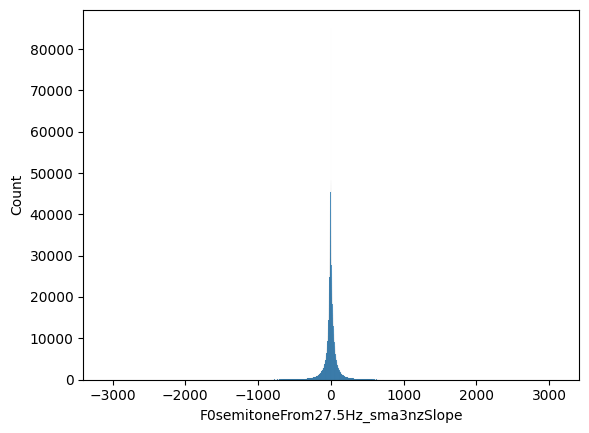

In [7]:
sns.histplot(x='F0semitoneFrom27.5Hz_sma3nzSlope', data=sample_10k)

In [8]:
top200 = sample_10k.content.value_counts().index.to_list()[:200]

In [9]:
sample_top200 = sample_10k[sample_10k['content'].isin(top200)]

In [10]:
sample_top200

,content,F0semitoneFrom27.5Hz_sma3nz,F1frequency_sma3nz,mfcc1_sma3,mfcc2_sma3,mfcc3_sma3,mfcc4_sma3,F0semitoneFrom27.5Hz_sma3nzSlope,F1frequency_sma3nzSlope,mfcc1_sma3Slope,mfcc2_sma3Slope,mfcc3_sma3Slope,mfcc4_sma3Slope
0,of,13.372669,709.972252,17.627483,11.882088,16.337697,3.473034,-538.578081,6524.478912,-376.016708,164.729478,230.000696,300.470206
2,but,6.901864,743.787904,8.244580,5.885458,13.293003,-0.155409,28.414856,-217.811986,19.415308,-8.778166,-1.277758,-55.507402
3,does,10.564279,691.468026,10.707017,7.465867,12.070202,-3.605176,31.394321,-324.730716,12.486669,-11.226081,2.389543,-34.655392
4,that,30.806327,526.894130,24.568225,-1.291678,16.486000,-25.644237,4.176154,209.619455,-7.214032,-14.171904,-11.736863,-21.604156
7,does,13.997172,597.205585,15.682532,0.581419,7.818629,0.787502,79.211961,-703.019250,27.146098,-20.559952,13.628544,-77.289081
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119994,this,8.845501,477.541860,7.203063,10.747156,-13.190065,-11.368051,-197.969038,1692.689209,-423.203688,445.040365,-133.515871,249.899429
5119995,is,24.801724,348.422485,-3.842635,31.195273,-20.521071,13.972470,6.921101,-6153.750610,407.483268,146.085835,-137.399387,325.209951
5119996,a,27.121097,330.940206,23.124772,8.153718,-6.723629,-10.152610,-104.509258,102.655792,404.647708,-730.151421,859.056973,-760.958862
5119998,but,29.350603,510.299013,23.557152,-16.624272,1.237855,-19.658682,-22.260890,437.219491,7.836444,-17.406065,-12.072126,-30.715111


In [11]:
sample_top200 = sample_top200.groupby('content').mean()

Text(0.5, 1.0, 'Scatter Plot of Top 200 Tokens: F1 Frequency vs F0 Semitone')

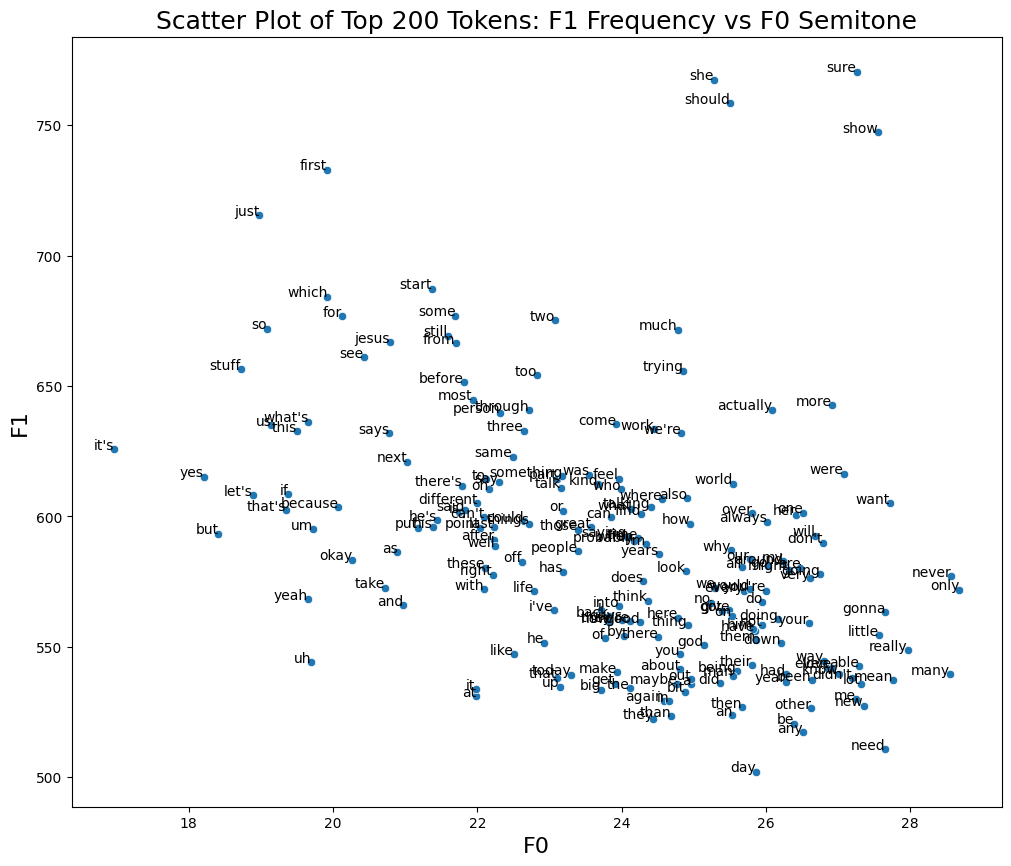

In [12]:
plt.figure(figsize=(12, 10), dpi=100)
sns.scatterplot(data=sample_top200, x='F0semitoneFrom27.5Hz_sma3nz', y='F1frequency_sma3nz')

for i in range(sample_top200.shape[0]):
    plt.text(
        sample_top200['F0semitoneFrom27.5Hz_sma3nz'].iloc[i],
        sample_top200['F1frequency_sma3nz'].iloc[i],
        sample_top200.index[i],
        fontsize=10,
        ha='right'
    )

plt.xlabel('F0', fontsize=16)
plt.ylabel('F1', fontsize=16)
plt.title('Scatter Plot of Top 200 Tokens: F1 Frequency vs F0 Semitone', fontsize=18)

# # Save the figure as a PNG
# plt.savefig('/shared/3/projects/bangzhao/prosodic_embeddings/figures/sample_top200_f0_f1.png', format='png')
# plt.show()

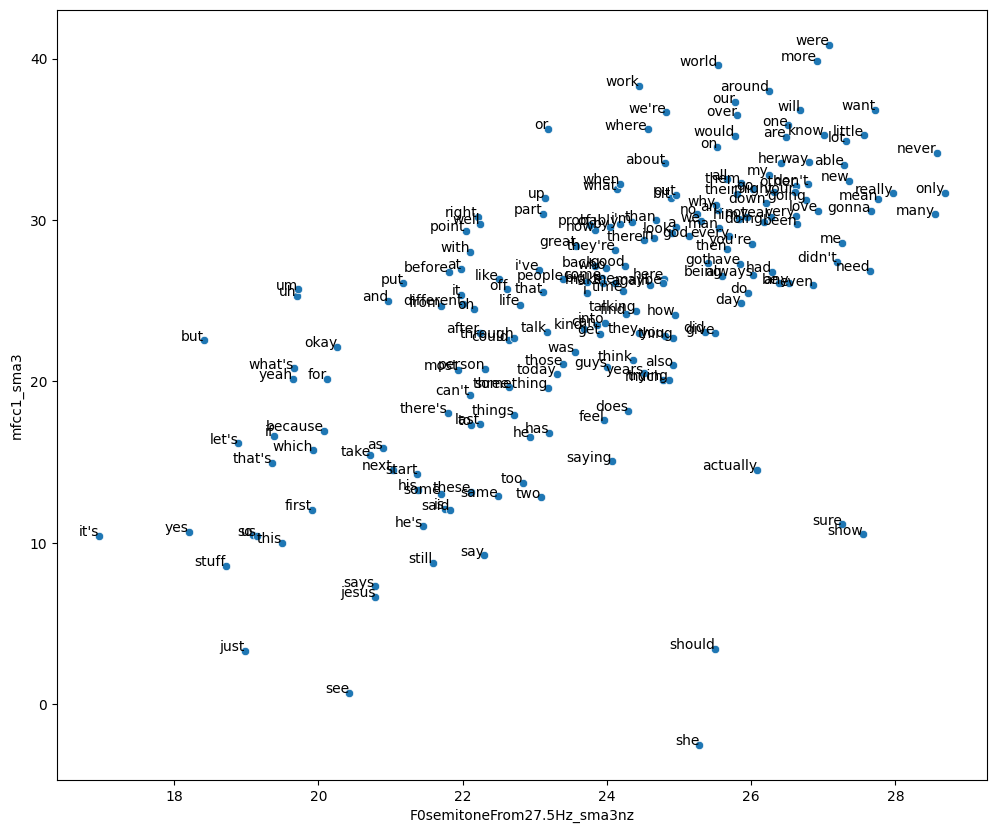

In [13]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=sample_top200, x='F0semitoneFrom27.5Hz_sma3nz', y='mfcc1_sma3')

for i in range(sample_top200.shape[0]):
    plt.text(
        sample_top200['F0semitoneFrom27.5Hz_sma3nz'].iloc[i],
        sample_top200['mfcc1_sma3'].iloc[i],
        sample_top200.index[i],
        fontsize=10,
        ha='right'
    )

plt.show()

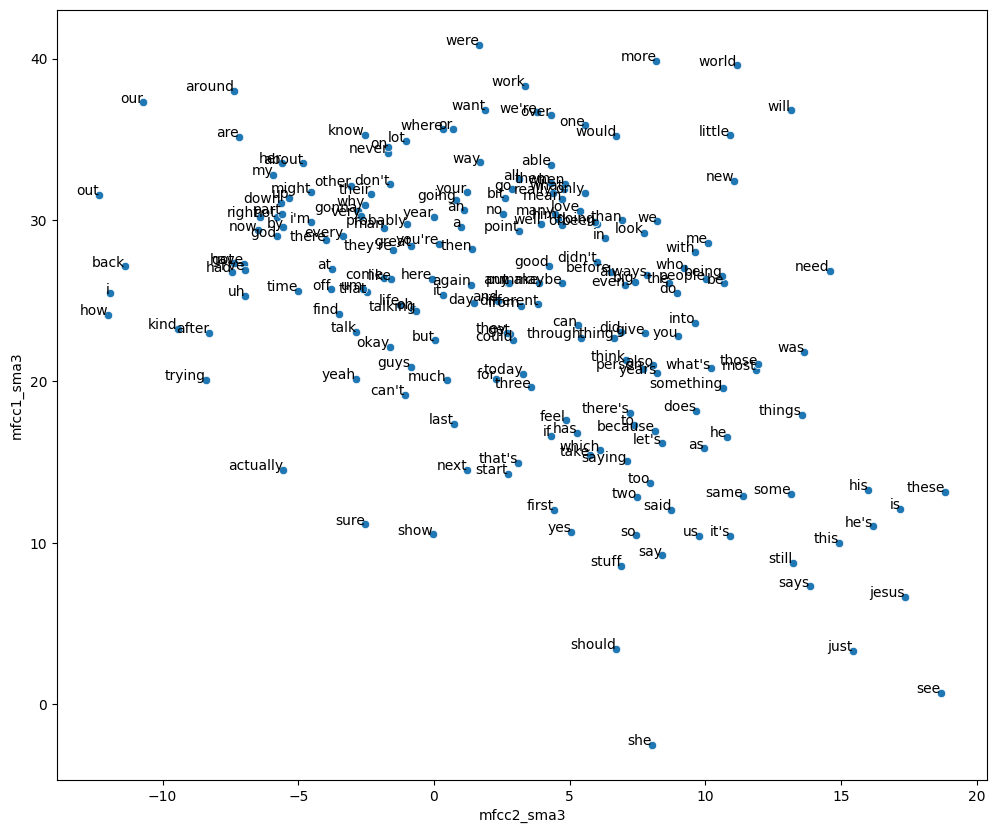

In [14]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=sample_top200, x='mfcc2_sma3', y='mfcc1_sma3')

for i in range(sample_top200.shape[0]):
    plt.text(
        sample_top200['mfcc2_sma3'].iloc[i],
        sample_top200['mfcc1_sma3'].iloc[i],
        sample_top200.index[i],
        fontsize=10,
        ha='right'
    )

plt.show()

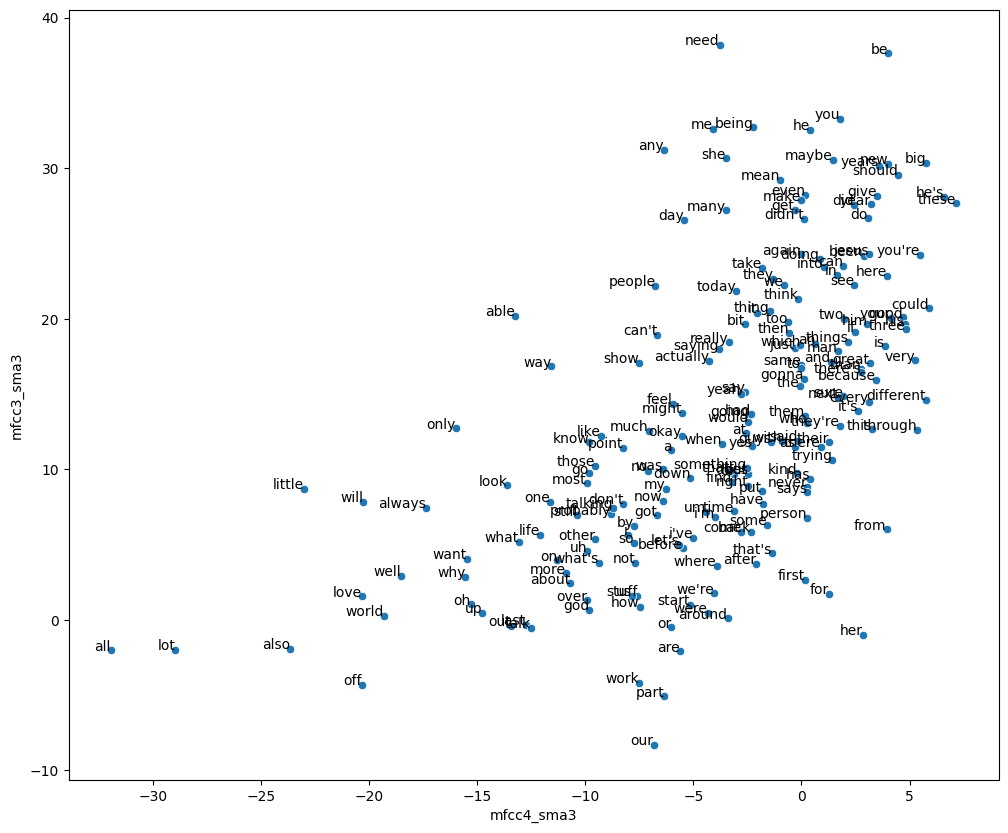

In [15]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=sample_top200, x='mfcc4_sma3', y='mfcc3_sma3')

for i in range(sample_top200.shape[0]):
    plt.text(
        sample_top200['mfcc4_sma3'].iloc[i],
        sample_top200['mfcc3_sma3'].iloc[i],
        sample_top200.index[i],
        fontsize=10,
        ha='right'
    )

plt.show()